In [1]:

import matplotlib
matplotlib.use('Agg')

import os
import pandas as pd
import numpy as np
import sys
import pickle
from scipy.spatial.distance import cdist
import math
import networkx as nx
import networkx.algorithms.components.connected as nxacc
import networkx.algorithms.dag as nxadag
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import mygene
import re
import difflib


In [2]:
# !wget -P ../data/gCSI https://zenodo.org/record/4737437/files/gCSI2.rds?download=1

In [3]:
def load_network(network_file_list, valid_gene_list):
    
    gene_neighbor_map = {}
    
    for file_name in network_file_list:
        
        ## print 'Load network', file_name
        
        file_handle = open(file_name)
    
        for line in file_handle:
        
            line = line.rstrip().split()
            gene1, gene2 = line[0], line[1]
        
            if gene1 not in valid_gene_list or gene2 not in valid_gene_list:
                continue
        
            if gene1 not in gene_neighbor_map:
                gene_neighbor_map[gene1] = set()
            if gene2 not in gene_neighbor_map:
                gene_neighbor_map[gene2] = set()
            
            gene_neighbor_map[gene1].add(gene2)
            gene_neighbor_map[gene2].add(gene1)
            
        file_handle.close()
    
    return gene_neighbor_map
                             
def load_name_space():
        
    go_tab_map = {}
    
    file_handle = open(go_name_space_file)
    
    for line in file_handle:
        line = line.rstrip().split()
        go_tab_map[line[0]] = line[1]
        
    file_handle.close()
    
    return go_tab_map
        
def list2index(cell_line_list, cell_line2id):
    
    cell_line_idx_list = []
    
    for cell_line in cell_line_list:
        cell_line_idx_list.append(cell_line2id[cell_line])
        
    return np.asarray(cell_line_idx_list)

In [14]:
data_file = '/data/references/original_data/GDSC/'
new_network_file = '/data/original_data/'

exp_data_file = data_file + 'Cell_line_RMA_proc_basalExp.txt'

drug_cell_line_file = data_file + 'v17_fitted_dose_response.csv'
#download at https://ftp.sanger.ac.uk/pub4/cancerrxgene/releases/release-6.0/v17_fitted_dose_response.xlsx

cell_line_detail_file = data_file + 'Cell_Lines_Details.csv'
mutation_data_file = data_file + 'WES_variants.csv'
drug_target_file ='/data/original_data/GDSC/drug_target_list.csv'

feature_folder = 'feature/'

inbiomap_file = 'InBioMap_Symbol.sif'
pathwaycomm_file = 'PathwayCommons_Symbol.sif'

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_row', 10)

PDTC_data_file = '/data/transfers/GRAY/'
PDTC_exp_data_file = PDTC_data_file + 'Expression.csv'
PDTC_drug_cell_line_file = PDTC_data_file + 'Drug_Response.csv'
#download at https://ftp.sanger.ac.uk/pub4/cancerrxgene/releases/release-6.0/v17_fitted_dose_response.xlsx

PDTC_cell_line_detail_file = PDTC_data_file + 'Cell_Lines_Details.csv'
PDTC_mutation_data_file = None
PDTC_drug_target_file ='/data/original_data/GDSC/drug_target_list.csv'

inbiomap_file = 'InBioMap_Symbol.sif'
pathwaycomm_file = 'PathwayCommons_Symbol.sif'

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_row', 10)


# 2. Merge GDSC and PDTC dataset

In [5]:
exp_df = pd.read_csv(exp_data_file, sep=',', index_col=0)
PDTC_exp_df = pd.read_csv(PDTC_exp_data_file, sep=',', index_col=0).fillna(0)
common_features = list(set(exp_df.columns.tolist()) & set(PDTC_exp_df.columns.tolist()))

In [6]:
exp_df = pd.read_csv(exp_data_file, sep=',', index_col=0)
#exp_df = exp_df.T[1:]
#exp_df = exp_df.rename(columns={np.nan: 'NO_GENE_NAME'})
#exp_df = exp_df.drop('NO_GENE_NAME',axis=1)

def stripNumber(line):
    m = re.match('DATA\.([0-9]+)\.?', line)
    return int(m.group(1))

exp_df.index = exp_df.index.map(stripNumber)
exp_df = exp_df.groupby(level=0).first()

exp_df = exp_df[common_features]
exp_gene_list = list(exp_df.columns)
exp_cell_line_list = list(exp_df.index.unique())


PDTC_exp_df = pd.read_csv(PDTC_exp_data_file, sep=',', index_col=0)
#exp_df = exp_df.T[1:]
#exp_df = exp_df.rename(columns={np.nan: 'NO_GENE_NAME'})
#exp_df = exp_df.drop('NO_GENE_NAME',axis=1)
#PDTC_exp_df.columns = [i.split("(")[0].strip() for i in exp_df.columns.tolist()]
def stripNumber(line):
    m = re.match('DATA\.([0-9]+)\.?', line)
    return int(m.group(1))
# return subgroup data in int

# exp_df.index = exp_df.index.map(stripNumber)
# exp_df = exp_df.groupby(level=0).first()
# group by rows

PDTC_exp_df = PDTC_exp_df[common_features]
PDTC_exp_gene_list = list(PDTC_exp_df.columns)
PDTC_exp_cell_line_list = list(PDTC_exp_df.index.unique())

exp_df = pd.concat([exp_df,PDTC_exp_df])
exp_gene_list = list(exp_df.columns)
exp_cell_line_list = list(exp_df.index.unique())
exp_df

,RAB8A,DEFB126,NVL,TCP10L,GDA,TJP2,IFNLR1,CAV2,MDK,FOXB1,...,MYH4,GPR183,LRRC41,ALX1,TMEM115,ANKRD42,MRPL37,HLCS,ZBTB37,RPAP1
683665,9.546070,2.916611,6.226956,3.721727,2.940616,6.889918,6.640870,3.202542,4.410167,2.967883,...,2.823245,6.973478,6.365979,2.868618,5.869166,3.252516,9.069897,4.542689,3.131438,6.285531
683667,8.231352,2.722589,6.113726,3.833149,2.866998,5.979140,3.322397,3.288323,7.548315,2.945358,...,2.690651,2.715693,6.436725,10.439098,7.010484,3.156315,8.905157,4.768418,3.206127,7.050174
684052,8.847747,2.778534,6.231362,5.745867,2.814787,4.856187,5.650797,11.630509,9.361850,2.905446,...,2.499803,2.641778,7.265143,6.911687,5.992191,3.164629,8.147144,5.611687,3.397375,7.074047
684055,7.851960,2.639580,6.804185,5.100564,2.748200,5.915273,5.959693,10.977377,10.349683,2.842781,...,2.489674,2.770891,7.855068,6.522509,6.588337,4.150160,8.979675,5.133463,3.372597,7.063724
684057,7.697232,2.941740,5.909296,5.197156,2.809990,4.282680,6.737310,9.510553,8.624472,3.022527,...,2.491254,2.683054,7.125793,7.750008,6.940556,3.564688,8.731208,4.872137,3.308869,8.171222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UACC-812,5.984431,-9.965784,3.286198,-2.111301,-3.115433,4.935915,0.435006,-0.373814,5.809749,-9.965784,...,-9.965784,-9.965784,5.426255,-9.965784,6.047396,2.536208,6.139302,3.879347,-0.004581,4.201281
UACC-893,5.450761,-9.965784,4.657650,-1.111586,-4.258389,5.271968,2.303381,0.533623,10.705347,-9.965784,...,-9.965784,-9.965784,5.533032,-9.965784,4.530061,3.637126,6.854119,2.898377,1.170725,5.275419
ZR-75-1,6.053772,-9.965784,4.938556,0.181580,-1.217435,4.571692,1.087228,-0.561424,6.492089,-9.965784,...,-9.965784,-3.739206,4.916659,-9.965784,4.671644,2.021257,6.168661,2.355490,-0.206979,3.860218
ZR-75-30,5.372019,-9.965784,4.731414,0.530925,-1.352696,5.841643,-6.199107,-0.273422,1.324259,-9.965784,...,-9.965784,-2.014414,5.400401,-9.965784,4.408357,1.009746,5.694396,3.555735,1.702269,3.358915


In [10]:
if PDTC_mutation_data_file is not None:
    mut_df = pd.read_csv(mutation_data_file, sep=',', index_col=0)
    mutation_df = mut_df.groupby(['COSMIC_ID', 'Gene']).size().unstack().fillna(0)
    PDTC_mut_df = pd.read_csv(PDTC_mutation_data_file, sep=',', index_col=0).fillna(0)
    common_features = list(set(mutation_df.columns.tolist()) & set(PDTC_mut_df.columns.tolist()))

In [11]:
maf = pd.read_csv(mutation_data_file, sep=',', index_col=0).fillna(0)
mutation_df = maf.groupby(['COSMIC_ID', 'Gene']).size().unstack().fillna(0)
if PDTC_mutation_data_file is not None: 
    mutation_df = mutation_df[common_features]


mutation_gene_list = list(mutation_df.columns)
mutation_cell_line_list = list(mutation_df.index.unique())


if PDTC_mutation_data_file is not None:
    PDTC_maf = pd.read_csv(PDTC_mutation_data_file, sep=',', index_col=0).fillna(0)
    PDTC_mutation_df= PDTC_maf.replace(to_replace="NO",value=0.0)
    PDTC_mutation_df= PDTC_mutation_df.replace(to_replace="chr*",value=1.0,regex=True)
    # print len(mutation_cell_line_list), len(mutation_gene_list)
    #PDTC_mutation_df = PDTC_mutation_df.transpose()
    PDTC_mutation_df = PDTC_mutation_df[common_features]
    PDTC_mutation_gene_list = list(PDTC_mutation_df.columns)
    PDTC_mutation_cell_line_list = list(PDTC_mutation_df.index.unique())

    mutation_df = pd.concat([mutation_df,PDTC_mutation_df])
    mutation_gene_list = list(mutation_df.columns)
    mutation_cell_line_list = list(mutation_df.index.unique())
    mutation_df

# 3. Match to drug target

## 3.1 GDSC

In [13]:
# process the drug-target profile to get a drug-target map
file_handle = open(drug_target_file)

drug_target_map = {} # drug - targets map
drug_target_list = [] # all potential targets
for line in file_handle:
    
    new_line = line.rstrip().split(",")
    drug = new_line[0]
    target_list=new_line[1].split(',')
    #target_list = [i.strip() for i in new_line[2:]]
    if drug != "Drug":
        target_list_str = ""
        for i in range(0,len(target_list)):
            if i == len(target_list) - 1:
                target_list_str += target_list[i].replace('"','')
            else:
                target_list_str += target_list[i].replace('"','') + ","
        drug = drug.strip()

        drug_target_map[drug] = []
        if ',' not in target_list_str:
            drug_target_map[drug].append(target_list_str.strip())
            drug_target_list.append(target_list_str.strip())
        else:
            target_list = target_list_str.split(',')
            for target in target_list:
                drug_target_map[drug].append(target.strip())
                drug_target_list.append(target.strip())

FileNotFoundError: [Errno 2] No such file or directory: '/data/original_data/GDSC/drug_target_list.csv'

## 3.2 PDTC

In [ ]:
file_handle = open(PDTC_drug_target_file)
for line in file_handle:
    new_line = line.rstrip().split(",")
    drug = new_line[0]
    target_list=new_line[1:]
    if drug != "Drug":
        target_list_str = ""
        for i in range(0,len(target_list)):
            if i == len(target_list) - 1:
                target_list_str += target_list[i].replace('"','')
            else:
                target_list_str += target_list[i].replace('"','') + ","
        drug = drug.strip()
        if drug not in list(drug_target_map.keys()):
            drug_target_map[drug] = []
        if ',' not in target_list_str:
            drug_target_map[drug].append(target_list_str.strip())
            drug_target_list.append(target_list_str.strip())
        else:
            target_list = target_list_str.split(',')
            for target in target_list:
                drug_target_map[drug].append(target.strip())
                drug_target_list.append(target.strip())

## 3.3 Check with 50 selected drugs in the paper

# Make new Screened Compounds file 

In [37]:
# drugs_legend = pd.read_csv('/data/GDSC/screened_coumpounds.csv', sep=',', index_col=0)
# drug2id_mapping = {}

# for index in list(drugs_legend.index) :
#     drug_name = drugs_legend.loc[index,'Drug Name']
#     drug2id_mapping[ drug_name ] = index
#     synonyms = str(drugs_legend.loc[index,"Synonyms"]).split(",")
#     for i in synonyms:
#         drug = i.strip()
#         drug2id_mapping[drug] = index

drugs_legend = pd.read_csv('/data/original_data/GDSC/New_Screened_Compounds.csv', sep=',', index_col=0)

drug2id_mapping = {}

for index in list(drugs_legend.index) :
    drug_name = drugs_legend.loc[index,'Drug Name']
    drug2id_mapping[ drug_name ] = index
    synonyms = str(drugs_legend.loc[index,"Synonyms"]).split(",")
    for i in synonyms:
        drug = i.strip()
        drug2id_mapping[drug] = index
# drug2id_mapping

# 4. Gene Map?

In [38]:
valid_gene_list = list(set(drug_target_list) | set(exp_gene_list) | set(mutation_gene_list))

network_list = [new_network_file+inbiomap_file, new_network_file+pathwaycomm_file]
gene_neighbor_map =  load_network(network_list, valid_gene_list)

gene_name_df = pd.read_table('/data/original_data/HUGO_protein-coding_gene.tsv',index_col=25, sep='\t')

gene_name_map = {}

for uniprot_gene in gene_name_df.index:
    ## print uniprot_gene
    if isinstance(uniprot_gene, type('aaa')) == False:
        # print(uniprot_gene)
        continue
    
    if isinstance(gene_name_df.loc[uniprot_gene, 'symbol'], type('aaa')) == False:
        gene_name_map[uniprot_gene] = gene_name_df.loc[uniprot_gene, 'symbol'][0]
    else:
        gene_name_map[uniprot_gene] = gene_name_df.loc[uniprot_gene, 'symbol']



/tmp/ipykernel_39/1040996744.py:6: DtypeWarning: Columns (31,38) have mixed types. Specify dtype option on import or set low_memory=False.
  gene_name_df = pd.read_table('/data/original_data/HUGO_protein-coding_gene.tsv',index_col=25, sep='\t')


In [39]:
# clarification needed

corum_df = pd.read_table(new_network_file + 'allComplexes.txt', index_col=0)

uniprot_gene_set = set()

for index in corum_df.index:
    
    if corum_df.loc[index, 'Organism'] != 'Human':
        continue
        
    complex_list = corum_df.loc[index, 'subunits(UniProt IDs)'].split(';')
    
    for gene in complex_list:
        uniprot_gene_set.add(gene)

# print len(uniprot_gene_set), 'genes'

query_gene_set = []

for gene in uniprot_gene_set:
    if gene not in gene_name_map:
        query_gene_set.append(gene)
    
# query the missing genes from gene_name_map

query_gene_list = list(query_gene_set)

mg = mygene.MyGeneInfo()
out = mg.querymany(query_gene_list, scopes='uniprot', fields='symbol', species='human')

not_found_gene_list = []

for i, gene in enumerate(query_gene_list):
    if 'notfound' in out[i]:
        not_found_gene_list.append(gene)
    else:
        gene_name_map[gene] = out[i]['symbol']
        
# print len(not_found_gene_list), 'symbol name not found', len(gene_name_map)

corum_df = pd.read_table(new_network_file + 'allComplexes.txt', index_col=0)

for index in corum_df.index:
    
    if corum_df.loc[index, 'Organism'] != 'Human':
        continue
    
    complex_list = corum_df.loc[index, 'subunits(UniProt IDs)'].split(';')
    
    complex_symbol_list = []
    
    for gene in complex_list:
        if gene in gene_name_map:
            complex_symbol_list.append( gene_name_map[gene] )

    for gene1, gene2 in itertools.combinations(complex_symbol_list,2):
        
        if gene1 not in gene_neighbor_map:
            gene_neighbor_map[gene1] = set()
        if gene2 not in gene_neighbor_map:
            gene_neighbor_map[gene2] = set()
        
        gene_neighbor_map[gene1].add(gene2)
        gene_neighbor_map[gene2].add(gene1)

gene_exp_neighbor_map = {}
exp_matrix = exp_df.values

P = 1 - cdist(np.transpose(exp_matrix), np.transpose(exp_matrix),'correlation')

for i in range(len(exp_gene_list)):
    
    gene1 = exp_gene_list[i]
    gene_exp_neighbor_map[gene1] = set()
    
    for j in range(len(exp_gene_list)):
        
        gene2 = exp_gene_list[j]
        
        if math.fabs(P[i, j]) > 0.4:
            gene_exp_neighbor_map[gene1].add(gene2)
            
    if gene1 not in gene_exp_neighbor_map[gene1]:
        print (gene1, 'not in itself?', P[i,i])



querying 1-43...done.
Finished.
26 input query terms found no hit:
	['A6QQ77', 'Q8IUB6', 'O15320', 'P62158', 'Q9Y2S0', 'Q9NZL9-', 'P48830', 'Q16198', 'Q3V639', 'Q13745'
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


## find drugs have mappable targets and those we can make features

In [40]:
# priority drugs - all drugs have mappable targets

In [41]:
drug_target_map = {k: v for k, v in drug_target_map.items() if v != ['']}

<AxesSubplot: ylabel='Count'>

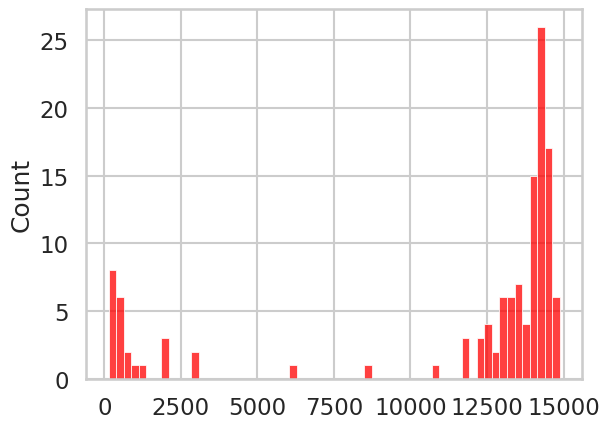

In [42]:
%matplotlib inline
drug_feature_list = []
drug_neighbor_map = {}
selected_drug_list = []
missing_drug_gene = {}
missing_genes = []

for drug, target_list in drug_target_map.items():
    drug_neighbor_map[drug] = set()

    for gene in target_list:

        if gene not in gene_exp_neighbor_map and gene not in gene_neighbor_map:
            # add to the missing drug-gene pair list for further investigation
            if drug in missing_drug_gene:
                missing_drug_gene[drug].append(gene)
            else:
                missing_drug_gene[drug] = [gene]

        if gene in gene_exp_neighbor_map:
            # concatenate the sets
            drug_neighbor_map[drug] = drug_neighbor_map[drug] | gene_exp_neighbor_map[gene]

        if gene in gene_neighbor_map:
            drug_neighbor_map[drug] = drug_neighbor_map[drug] | gene_neighbor_map[gene]
            # gene_neighbor_map - find potential targets (correlated genes)

    if len(drug_neighbor_map[drug]) != 0:
        selected_drug_list.append(drug)
        drug_feature_list.append(len(drug_neighbor_map[drug])) # number of associated gene per drug

sns.set_style("whitegrid")
sns.set_context("talk")
# sns.distplot(drug_feature_list,color='r',bins=60,kde=False,norm_hist=False)
sns.histplot(drug_feature_list,color='r',bins=60,kde=False)

In [43]:
# selected drug list: which one has the actual gene target

In [44]:
# discrepancy between drugs in paper and priority drugs

In [45]:
drugs = pd.read_csv(drug_cell_line_file,index_col=2)
drugs = drugs.drop(["DATASET_VERSION","IC50_RESULTS_ID","MAX_CONC_MICROMOLAR","RMSE"],axis=1)
drugs_cell_line_list = list(drugs.index.unique())
# print len(drugs_cell_line_list)
drug_list = drugs["DRUG_ID"]
drugs = drugs[["DRUG_ID","LN_IC50"]]

PDTC_drugs = pd.read_csv(PDTC_drug_cell_line_file,index_col=0)
PDTC_drugs.index = PDTC_drugs["cell"].tolist()
#drugs = drugs.drop(["DATASET_VERSION","IC50_RESULTS_ID","MAX_CONC_MICROMOLAR","RMSE"],axis=1)
PDTC_drugs["LN_IC50"] = np.log(PDTC_drugs["ic50"])
# print len(drugs_cell_line_list)
available_PDTC_drugs = [i for i in PDTC_drugs["drug"].tolist() if i in drug2id_mapping.keys()]
PDTC_drugs["DRUG_ID"] = [drug2id_mapping[i] if i in drug2id_mapping.keys() else i for i in PDTC_drugs["drug"].tolist()]
PDTC_drugs = PDTC_drugs[["DRUG_ID","LN_IC50"]]
PDTC_drugs_list = PDTC_drugs["DRUG_ID"]
PDTC_drugs.columns = ["DRUG_ID","LN_IC50"]


drugs = pd.concat([drugs,PDTC_drugs])

drugs_cell_line_list = list(drugs.index.unique())

/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [47]:
common_drugs = list(set(drug_list) & set(PDTC_drugs_list))

In [50]:
drugs = drugs[drugs["DRUG_ID"].isin(common_drugs)]

## find a giant cell line list across GDSC + PDTC

In [52]:
cell_line_legend = pd.read_csv(cell_line_detail_file, index_col=1)

In [55]:
if PDTC_mutation_data_file is not None:
    cell_line_list = list(set(drugs_cell_line_list)&set(exp_cell_line_list)&set(mutation_cell_line_list))
else:
    cell_line_list = list(set(drugs_cell_line_list)&set(exp_cell_line_list))
cell_line_legend = pd.read_csv(cell_line_detail_file, index_col=1)


#cell_line_legend.columns = ["Site"]
#PDTC_cell_line = pd.DataFrame({'Line': ["BRCA"]*len(PDTC_exfp_cell_line_list), 'Site':["PDTC"]*len(PDTC_exp_cell_line_list),"Histology":["breast"]*len(PDTC_exp_cell_line_list)},index=PDTC_exp_cell_line_list)
PDTC_cell_line = pd.read_csv(PDTC_cell_line_detail_file, index_col=1)[["line","site"]]
PDTC_cell_line["histology"] = PDTC_cell_line["site"]
PDTC_cell_line.columns = cell_line_legend.columns.tolist()

cell_line_legend = pd.concat([cell_line_legend,PDTC_cell_line])


In [56]:
cell_line_list = list(set(cell_line_legend.index.tolist()) & set(cell_line_list)) 

In [57]:
cell_line_legend["Site"] = [i.replace(" ", "_") for i in cell_line_legend["Site"].tolist()]

In [58]:
cell_line_legend["Site"] = [i.split("/")[0] for i in cell_line_legend["Site"].tolist()]

In [60]:
# identify the tissue the cell belong to
tissue_map = {}

for cell_line in cell_line_list:
    
    tissue = cell_line_legend.loc[cell_line,'Site']
    
    if tissue not in tissue_map:
        tissue_map[tissue] = []
        
    tissue_map[tissue].append(cell_line)

large_tissue_number = 0
for tissue, cell_line in tissue_map.items():
    
    if len(cell_line) >= 15:
        large_tissue_number += 1
    
    print (tissue, len(cell_line))
    # # of cell lines each tissue correspond to

print('How many tissues', len(tissue_map))
print('Large tissues', large_tissue_number)


haematopoietic_and_lymphoid_tissue 163
BeatAML 217
central_nervous_system 56
stomach 28
bone 40
pancreas 32
large_intestine 48
lung 169
soft_tissue 22
urinary_tract 19
autonomic_ganglia 29
oesophagus 35
upper_aerodigestive_tract 42
ovary 41
breast 50
cervix 13
endometrium 11
thyroid 15
skin 55
liver 16
adrenal_gland 1
vulva 3
prostate 7
biliary_tract 5
kidney 31
salivary_gland 2
pleura 21
NS 3
testis 2
small_intestine 1
placenta 2
How many tissues 31
Large tissues 20


In [61]:
# filter mutation / genes that are under-expressed 

In [62]:
new_exp_gene_list = []
for i in exp_gene_list:
    if i in valid_gene_list:
        new_exp_gene_list.append(i)

exp_stdev = np.std(exp_df.values, axis=0)
exp_perc = np.percentile(exp_stdev,10)
filtered_exp_gene_list = np.asarray(exp_gene_list)[exp_stdev > exp_perc]

mut_sum = np.sum(mutation_df.values,axis=0)
filtered_mut_gene_list = np.asarray(mutation_gene_list)[mut_sum > 5]

new_exp_df = exp_df.loc[ :, list(filtered_exp_gene_list) ]
new_mutation_df = mutation_df.loc[ :, list(filtered_mut_gene_list) ]

new_data_file = ''

exp_stdev = np.std(exp_df.values, axis=0)
exp_perc = np.percentile(exp_stdev,10)
filtered_exp_gene_list = np.asarray(exp_gene_list)[exp_stdev > exp_perc]

mut_sum = np.sum(mutation_df.values,axis=0)
filtered_mut_gene_list = np.asarray(mutation_gene_list)[mut_sum > 5]

new_exp_df = exp_df.loc[ :, list(filtered_exp_gene_list) ]
new_mutation_df = mutation_df.loc[ :, list(filtered_mut_gene_list) ]

if PDTC_mutation_data_file is not None:
    common_genes = list(set(new_exp_df.columns.tolist()) & set(new_mutation_df.columns.tolist()))
    new_mutation_df = new_mutation_df[common_genes]
    filtered_mut_gene_list = common_genes
else:
    common_genes = new_exp_df.columns.tolist()
    filtered_mut_gene_list = []
new_exp_df= new_exp_df[common_genes]
filtered_exp_gene_list = common_genes


common_cells = list(set(new_exp_df.index.tolist()) & set(new_mutation_df.index.tolist()))
new_exp_df= new_exp_df.loc[~new_exp_df.index.duplicated(),:].copy()
new_mutation_df = new_mutation_df.loc[~new_mutation_df.index.duplicated(),:].copy()

In [63]:
drugs = drugs.drop_duplicates()

In [64]:
selected_drug_list = [i for i in selected_drug_list if i in drug2id_mapping]

In [65]:
selected_drug_list = list(set(selected_drug_list) & set(available_PDTC_drugs))

In [66]:
rename_selected_drug_list = []

for drug in selected_drug_list:
    print(drug)
    
    if drug not in drug2id_mapping:
        print('drug name wrong', drug)
    else:
        cell_line_drug_matrix = drugs.loc[drugs['DRUG_ID'] == drug2id_mapping[drug]]
        if len(cell_line_drug_matrix) == 0:
            continue
        feature_exp_gene_list = list( set(drug_neighbor_map[drug]) & set(filtered_exp_gene_list) )
        feature_mut_gene_list = list( set(drug_neighbor_map[drug]) & set(filtered_mut_gene_list) )
        if len(feature_exp_gene_list) + len(feature_mut_gene_list) == 0:
            continue
        feature_description = []

        drug_tissue_map = {}

        drug = drug.replace(' ','_')

        # print drug
        if drug == 'Nutlin-3a_(-)':
            drug = 'Nutlin-3a'

        drug_folder = '/data/GDSC1_BeatAML/drug_feature/' + drug + '/'
        if not os.path.exists(drug_folder):
            os.makedirs(drug_folder)

        # print 'Generate features', drug

        for tissue, tissue_cell_line_list in tissue_map.items():
            drug_specific_cell_line = set( cell_line_drug_matrix.index ) & set( tissue_cell_line_list )
            drug_specific_cell_line = list(drug_specific_cell_line)
            drug_tissue_map[tissue] = drug_specific_cell_line

            feature_list = []

            if len(feature_exp_gene_list) != 0:
                feature_list.append( new_exp_df.loc[ drug_specific_cell_line, feature_exp_gene_list ].values )
                for gene in feature_exp_gene_list:
                    feature_description.append(gene+'_expression')

            if len(feature_mut_gene_list) != 0:
                feature_list.append( mutation_df.loc[ drug_specific_cell_line, feature_mut_gene_list ].values )
                for gene in feature_mut_gene_list:
                    feature_description.append(gene+'_mutation')

            feature = np.concatenate(feature_list, axis=1)

            label = cell_line_drug_matrix.loc[ drug_specific_cell_line,'LN_IC50'].values
            if feature.shape[0] != label.shape[0]:
                print(f"Feature shape: {feature.shape}")
                print(f"Label shape: {label.shape}")
            #label = new_crispr_df.loc[ tissue_cell_line_list, label_gene ].values

            # print feature.shape, label.shape

            np.save(drug_folder + tissue + '_' + drug + '_feature.npy', feature )
            np.save(drug_folder + tissue + '_' + drug + '_label.npy', label)
            np.save(drug_folder + tissue + '_feature_description.npy', np.asarray(feature_description))

        file_handle = open("/data/GDSC1_BeatAML/" + drug+'_tissue_cell_line_list.pkl',"wb")
        pickle.dump(drug_tissue_map,file_handle)
        file_handle.close()
    
file_handle = open('rename_selected_drug_list', 'w')
for drug in rename_selected_drug_list:
    file_handle.writelines(drug+ '\n')
file_handle.close()

Erlotinib
Dasatinib
Gefitinib
Ruxolitinib
Masitinib
Midostaurin
Lapatinib
MK-2206
Afatinib
GSK-1904529A
PLX4720
BI-2536
Axitinib
Sunitinib
Crizotinib
Imatinib
Pazopanib
Vismodegib
AT-7519
KU-55933
Sorafenib
Bosutinib


In [67]:
drug_feature_dir = os.listdir("/data/GDSC1_BeatAML//drug_feature/")
pickle_files = os.listdir("/data/GDSC1_BeatAML/")

In [68]:
for i in pickle_files:
    if "pkl" in i:
        drug = i.split("_tissue")[0]
        if drug not in drug_feature_dir:
            print(drug)
            os.system(f"rm /data/GDSC1_BeatAML/{i}")